# Imports

In [81]:
import os 
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

<br>

# Explanation

This data splitter will explore the spurious correlation that might arise between right and left eye images for a certain severity level. If the model was trained only on right-eye images with non-referrable severity levels (0 and 1) images and tested on right-eye images with referrable severity levels (2 to 4), there are two possible outcomes. If the model learns the spurious relationship between the side of the eye and the severity it will classify the test samples with lower severity scores. If the model is robust enough to the spurious correlation it will most probably classify the test images correctly regardless of the eye-side bias introduced in the data split.

<br>

# Common Functions

In [82]:
def detect_image_extension(image_folder):
    IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp')
    image_paths = glob(f'{image_folder}/**/**')
    assert len(image_paths), 'The images folder is empty! Please correct the folder path.'
    extension = os.path.splitext(image_paths[0])[-1]
    assert extension in IMG_EXTENSIONS, 'The images folder must only contain images files with consistent format.'
    return extension

<br>

# Definitions

In [159]:
# Path to image folder
IMG_FOLDER = '../datasets/eyepacs/'
# Path to the file containing the image labels
IMG_LABELS_FILE = '../datasets/eyepacs/labels_filt.csv'
IMAGE_EXT = detect_image_extension(IMG_FOLDER)
SEED = 100

In [84]:
def get_dataset_with_metadata(df):
    df_img_info = df.copy()
    # Separates the patient ID from the eye-side information
    image_name_info = df_img_info['image'].str.split('_', expand=True)
    image_name_info.columns = ['patient_id', 'side']
    df_img_info = pd.concat([image_name_info, df_img_info], axis=1)
    df_img_info['image']  = df_img_info['level'].astype('str') + '/' + df_img_info['image'] + IMAGE_EXT
    # Referrable and non-referrable levels
    df_img_info['level_group'] = df_img_info['level'].map(lambda val: 'nref' if val <= 1 else 'ref')
    df_img_info['groups'] = df_img_info['side'] + '_' + df_img_info['level_group']
    return df_img_info

<br>

# Splitting data based on eye side, severity and frequency

## Preparing useful informationm

In [160]:
# Reading the labels data
df_labels = pd.read_csv(IMG_LABELS_FILE)
df_labels = df_labels[['image', 'level']]
# The image info will gather the useful information for splitting
df_img_info = get_dataset_with_metadata(df_labels)


In [161]:
df_img_info

,patient_id,side,image,level,level_group,groups
0,1,left,0/1_left.jpeg,0,nref,left_nref
1,1,right,0/1_right.jpeg,0,nref,right_nref
2,2,left,0/2_left.jpeg,0,nref,left_nref
3,2,right,0/2_right.jpeg,0,nref,right_nref
4,3,left,2/3_left.jpeg,2,ref,left_ref
...,...,...,...,...,...,...
86917,44349,right,1/44349_right.jpeg,1,nref,right_nref
86918,44350,left,0/44350_left.jpeg,0,nref,left_nref
86919,44350,right,0/44350_right.jpeg,0,nref,right_nref
86920,44351,left,0/44351_left.jpeg,0,nref,left_nref


# Handling Data Imbalance

In [162]:
label_count = df_img_info['level'].value_counts()

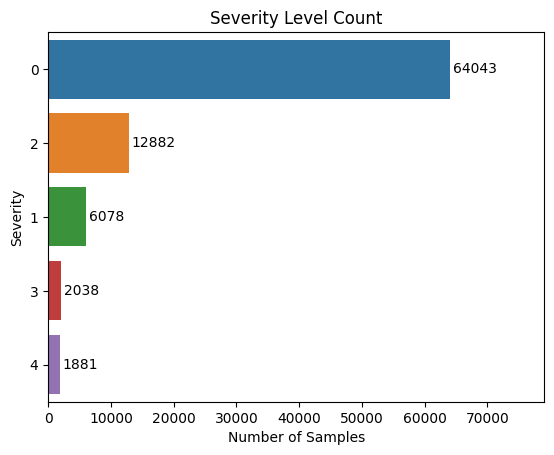

In [163]:
#fig, axes = plt.subplots(nrows=1, ncols=2)
plt.figure()
countplot = sns.countplot(y=df_img_info['level'], order=label_count.index)
countplot.bar_label(countplot.containers[0], padding=2)
plt.title('Severity Level Count')
plt.xlabel('Number of Samples')
plt.xlim(0, label_count.iloc[0] + 15e3)
plt.ylabel('Severity')
plt.show()

## Grouping by Order

In [164]:
# fifth biggest number of samples
base_severity = 4

In [165]:
order_counts = label_count.iloc[base_severity]

In [166]:
left_severity_count = len(df_img_info.query(f'(side == "left") and level == {base_severity}'))

In [167]:
right_severity_count = len(df_img_info.query(f'(side == "right") and level == {base_severity}'))

In [168]:
if left_severity_count <= right_severity_count:
    num_samples_side = left_severity_count
else:
    num_samples_side = right_severity_count

In [169]:
df_img_info_balanced = df_img_info.groupby(['level', 'side']) \
                                  .sample(num_samples_side, 
                                          replace=False, random_state=100)

## Second Highest

In [95]:
# Getting second highest class since there is a considerable imbalance
# between class 0 and the other classes
num_samples_second_highest = label_count.iloc[1].item()
# Handling odd number (irregularity due to right and left eye of same individual with different DR severities)
if num_samples_second_highest % 2 != 0:
    num_samples_second_highest += 1

In [99]:
num_samples_second_highest

13154

Since the number of samples is fixed based on class 2, class 0 will be undersampled and classes 1,3, and 4 will be oversampled. The sampling will be done grouping by severity and eye side to make it more consistent and remove any bias previous to the spurious splitting situation.

In [44]:
df_img_info_balanced = df_img_info.groupby(['level', 'side']) \
                                  .sample(num_samples_second_highest // 2, 
                                          replace=True, random_state=100)

In [45]:
balanced_label_count = df_img_info_balanced['level'].value_counts()
balanced_label_count

0    5288
1    5288
2    5288
3    5288
4    5288
Name: level, dtype: int64

## Balanced Graph

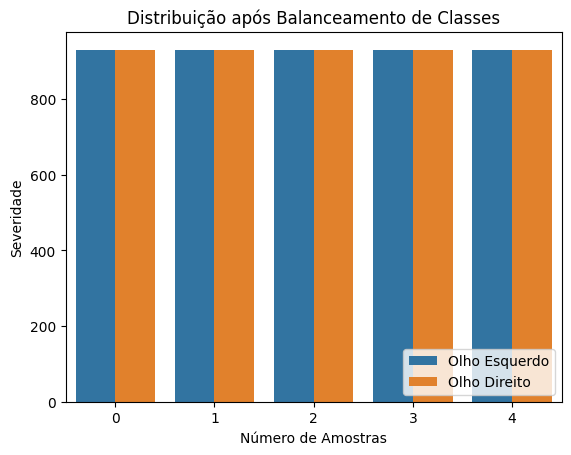

In [171]:
#plt.figure(figsize=(8,6))
sns.countplot(data=df_img_info_balanced, x='level', hue='side')
plt.title('Distribuição após Balanceamento de Classes')
plt.xlabel('Número de Amostras')
plt.legend(loc='lower right', labels=['Olho Esquerdo', 'Olho Direito'])
plt.ylabel('Severidade')
plt.show()

In [145]:
df_img_info_balanced.head()

,patient_id,side,image,level,level_group,groups
70072,35037,left,0/35037_left.jpeg,0,nref,left_nref
39018,19510,left,0/19510_left.jpeg,0,nref,left_nref
5308,2655,left,0/2655_left.jpeg,0,nref,left_nref
52088,26045,left,0/26045_left.jpeg,0,nref,left_nref
33736,16869,left,0/16869_left.jpeg,0,nref,left_nref


In [48]:
#df_img_info_balanced = df_img_info_balanced.sort_index(ignore_index=True)

## Splitting Images

First, we need to first define two important sets, the environment set $\mathcal{E}$ and the labels set $\mathcal{Y}$

$$
\large \mathcal{E} = \{left,\;right\}
$$

$$
\large \mathcal{Y} = \{nref,\; ref\}\; 
$$

$where:$
\begin{equation*}    
    \begin{aligned}
        &nref = \{0,1\}\\
        &ref = \{2,3,4\}
    \end{aligned}
\end{equation*}

# Parameters

In [172]:
GROUPS = set(['left_nref', 'right_ref', 'left_ref', 'right_nref'])

In [173]:
#[Train, Val, Test]
DATA_SPLIT = [0.8, 0.1, 0.1]

In [174]:
MAJORITY_TRAIN_GROUPS = {'left_nref', 'right_ref'}
MINORITY_TRAIN_GROUPS = GROUPS.difference(MAJORITY_TRAIN_GROUPS)
TRAIN_SIZE = 0.9
MAJORITY_PROPORTION = 0.9
VAL_PCT_FROM_TRAIN = 0.1

# Balanced Baseline Splitting

In [175]:
df_balanced_train_val, df_balanced_test = train_test_split(
    df_img_info_balanced, 
    train_size=TRAIN_SIZE, 
    stratify=df_img_info_balanced['level'],
    random_state=100)

In [176]:
df_balanced_train, df_balanced_val = train_test_split(
    df_balanced_train_val, 
    train_size=VAL_PCT_FROM_TRAIN, 
    stratify=df_balanced_train_val['level'],
    random_state=100)

In [177]:
print(('Train:'
      f'\n- Number of samples: {len(df_balanced_train)}'
      f'\n- Percentage from Original: {round(len(df_balanced_train)/len(df_img_info_balanced), 2)}'))
print(('\nValidation:'
      f'\n- Number of samples: {len(df_balanced_val)}'
      f'\n- Percentage from Original: {round(len(df_balanced_val)/len(df_img_info_balanced), 2)}'))
print(('\nTest:'
      f'\n- Number of samples: {len(df_balanced_test)}'
      f'\n- Percentage from Original: {round(len(df_balanced_test)/len(df_img_info_balanced), 2)}'))


Train:
- Number of samples: 837
- Percentage from Original: 0.09

Validation:
- Number of samples: 7542
- Percentage from Original: 0.81

Test:
- Number of samples: 931
- Percentage from Original: 0.1


In [178]:
# Balanced training
df_balanced_baseline = df_img_info_balanced

In [179]:
# Train
df_balanced_baseline.loc[df_balanced_baseline.index.isin(df_balanced_train.index), 'split'] = 'train'
# Validation
df_balanced_baseline.loc[df_balanced_baseline.index.isin(df_balanced_val.index), 'split'] = 'val'
# Test
df_balanced_baseline.loc[df_balanced_baseline.index.isin(df_balanced_test.index), 'split'] = 'test'

In [180]:
df_balanced_baseline.to_csv(os.path.join(IMG_FOLDER, 'metadata_balanced_train_baseline.csv'), index=False)

# Balanced Splitting

In [196]:
num_samples_train = int(TRAIN_SIZE*len(df_img_info_balanced))
num_samples_majority_train = int(num_samples_train*MAJORITY_PROPORTION)

In [205]:
majority_group_pct = round(MAJORITY_PROPORTION / len(MAJORITY_TRAIN_GROUPS), 2)

In [206]:
minorty_group_pct = round((1 - MAJORITY_PROPORTION) / len(MINORITY_TRAIN_GROUPS), 2)

In [211]:
pct_distribution = [*([majority_group_pct]*len(MAJORITY_TRAIN_GROUPS)), *([minorty_group_pct]*len(MINORITY_TRAIN_GROUPS))]

In [216]:
ordered_groups = [*list(MAJORITY_TRAIN_GROUPS), *list(MINORITY_TRAIN_GROUPS)]

In [221]:
dist_train_samples = pd.DataFrame(zip(ordered_groups, pct_distribution), columns=['group', 'pct_samples'])

In [223]:
dist_train_samples['n_samples'] = (dist_train_samples['pct_samples'] * num_samples_train).round()

In [261]:
# Get minimum count
max_possible_group_val = df_img_info_balanced.groupby('groups')['side'].count().min()
# Adding a 10% tolerance
max_possible_group_val = round(max_possible_group_val*0.9)

In [262]:
total_samples = int(max_possible_group_val / 0.45)

In [263]:
total_samples

10575

In [264]:
dist_train_samples['n_samples'] = total_samples * dist_train_samples['pct_samples']

In [265]:
dist_train_samples['n_samples'] = dist_train_samples['n_samples'].astype('int')

In [266]:
dist_train_samples

,group,pct_samples,n_samples
0,left_nref,0.45,4758
1,right_ref,0.45,4758
2,left_ref,0.05,528
3,right_nref,0.05,528


## Creating partitioning

In [296]:
from sklearn.model_selection import train_test_split

In [301]:
train_val_indexes = []

In [302]:
for row in dist_train_samples.itertuples():
    df_group = df_img_info_balanced.query('groups == @row.group')
    train_val_indexes.extend(df_group.sample(row.n_samples).index)

In [303]:
test_indexes = df_img_info_balanced.index.difference(train_val_indexes)

In [304]:
train_val_indexes = sorted(train_val_indexes)

In [305]:
df_train_val = df_img_info_balanced.loc[train_val_indexes]

In [307]:
df_train, df_val = train_test_split(df_train_val, stratify=df_train_val['groups'], test_size=VAL_PCT_FROM_TRAIN, random_state=100)

In [308]:
df_img_info_balanced['split'] = np.nan

In [310]:
# Train
df_img_info_balanced.loc[df_img_info_balanced.index.isin(df_train.index), 'split'] = 'train'
# Validation
df_img_info_balanced.loc[df_img_info_balanced.index.isin(df_val.index), 'split'] = 'val'
# Test
df_img_info_balanced.loc[df_img_info_balanced.index.isin(test_indexes), 'split'] = 'test'

In [320]:
df_img_info_balanced.groupby('split')['groups'].value_counts(normalize=True).round(decimals=2).to_frame()

groups
split groups            
test  left_ref      0.47
      right_nref    0.30
      right_ref     0.20
      left_nref     0.03
train left_nref     0.45
      right_ref     0.45
      left_ref      0.05
      right_nref    0.05
val   left_nref     0.45
      right_ref     0.45
      left_ref      0.05
      right_nref    0.05

## Majority Groups

In [189]:
for majority_group in MAJORITY_TRAIN_GROUPS:
    df_majority_group = df_img_info_balanced.query('groups == @majority_group')
    indexes_majority_group_train = df_majority_group.sample(num_samples_majority_group_train).index
    partition_split_indexes['train'].extend(indexes_majority_group_train)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
for majority_group in MAJORITY_TRAIN_GROUPS:
    

In [176]:
df_img_info_balanced

,patient_id,side,image,level,level_group,groups
0,15,left,1/15_left.jpeg,1,nref,left_nref
1,15,left,1/15_left.jpeg,1,nref,left_nref
2,15,right,2/15_right.jpeg,2,ref,right_ref
3,16,left,4/16_left.jpeg,4,ref,left_ref
4,16,left,4/16_left.jpeg,4,ref,left_ref
...,...,...,...,...,...,...
26435,44328,right,1/44328_right.jpeg,1,nref,right_nref
26436,44328,right,1/44328_right.jpeg,1,nref,right_nref
26437,44343,left,0/44343_left.jpeg,0,nref,left_nref
26438,44347,left,0/44347_left.jpeg,0,nref,left_nref


In [154]:
num_samples_train

4759

In [321]:
OUTPUT_PATH = os.path.join(IMG_FOLDER, 'metadata_balanced.csv')
df_img_info.to_csv(OUTPUT_PATH, index=False)

# Imbalanced Splitting

In [139]:
df_major_groups_train = df_img_info.loc[df_img_info.groups.isin(MAJORITY_TRAIN_GROUPS)]

In [140]:
df_minor_groups_train = df_img_info.loc[df_img_info.index.difference(df_major_groups_train.index)]

In [141]:
majority_train, minority_test = train_test_split(
    df_major_groups_train, 
    stratify=df_major_groups_train['groups'], 
    train_size=MAJORITY_PROPORTION,
    random_state=SEED)

In [142]:
minority_train_size = round((len(majority_train) / MAJORITY_PROPORTION) * (1 - MAJORITY_PROPORTION))

In [143]:
majority_test, minority_train = train_test_split(
    df_minor_groups_train, 
    stratify=df_minor_groups_train['groups'], 
    test_size=minority_train_size / len(df_minor_groups_train),
    random_state=SEED)

In [144]:
# Taking part of training for validation
train_images = pd.concat([majority_train, minority_train], axis=0, sort=True)

In [145]:
train_images, val_images = train_test_split(
    train_images, 
    stratify=train_images['groups'],
    test_size=VAL_PCT_FROM_TRAIN,
    random_state=SEED)

In [146]:
test_images = pd.concat([majority_test, minority_test], axis=0, sort=True)

In [147]:
# Group distribution
print(f'Train:')
pprint(train_images['groups'].value_counts(normalize=True).round(decimals=2).to_dict())
print(f'Validation:')
pprint(val_images['groups'].value_counts(normalize=True).round(decimals=2).to_dict())
print(f'Test:')
pprint(test_images['groups'].value_counts(normalize=True).round(decimals=2).to_dict())

Train:
{'left_nref': 0.36, 'left_ref': 0.06, 'right_nref': 0.04, 'right_ref': 0.54}
Validation:
{'left_nref': 0.36, 'left_ref': 0.06, 'right_nref': 0.04, 'right_ref': 0.54}
Test:
{'left_nref': 0.04, 'left_ref': 0.54, 'right_nref': 0.36, 'right_ref': 0.06}


In [148]:
# Group total samples
print(f'Train:')
pprint(train_images['groups'].value_counts().round(decimals=2).to_dict())
print(f'Validation:')
pprint(val_images['groups'].value_counts().round(decimals=2).to_dict())
print(f'Test:')
pprint(test_images['groups'].value_counts().round(decimals=2).to_dict())

Train:
{'left_nref': 4283, 'left_ref': 714, 'right_nref': 476, 'right_ref': 6425}
Validation:
{'left_nref': 476, 'left_ref': 79, 'right_nref': 53, 'right_ref': 714}
Test:
{'left_nref': 529, 'left_ref': 7139, 'right_nref': 4759, 'right_ref': 793}


<br>

# Saving outputs splits

In [72]:
metadata = df_img_info

In [73]:
# Transforming to relative image path from the dataset folder
metadata['image'] = metadata['image'].str.replace('../datasets/', '', regex=False)

In [74]:
metadata['split'] = np.nan

In [75]:
# Training set
metadata.loc[train_images.index, 'split'] = 'train'

In [76]:
# Validation set
metadata.loc[val_images.index, 'split'] = 'val'

In [77]:
# Test set
metadata.loc[test_images.index, 'split'] = 'test'

In [78]:
metadata

,patient_id,side,image,level,level_group,groups,split
0,10,left,0/10_left.jpeg,0,nref,left_nref,val
1,10,right,0/10_right.jpeg,0,nref,right_nref,test
2,13,left,0/13_left.jpeg,0,nref,left_nref,train
3,13,right,0/13_right.jpeg,0,nref,right_nref,test
4,15,left,1/15_left.jpeg,1,nref,left_nref,test
...,...,...,...,...,...,...,...
35103,44347,right,0/44347_right.jpeg,0,nref,right_nref,test
35104,44348,left,0/44348_left.jpeg,0,nref,left_nref,train
35105,44348,right,0/44348_right.jpeg,0,nref,right_nref,test
35106,44349,left,0/44349_left.jpeg,0,nref,left_nref,train


In [79]:
OUTPUT_PATH = os.path.join(IMG_FOLDER, 'metadata.csv')
df_img_info.to_csv(OUTPUT_PATH, index=False)

<br>